<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/2024F/notebooks/6_automatic_music_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Download Dataset

In [1]:
!gdown --id 1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
!unzip -q maestro_small.zip


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
From (redirected): https://drive.google.com/uc?id=1L99FSzloXGQsmc-OwsVKggvQNF9niN2M&confirm=t&uuid=e8742b79-cb63-4b7d-9024-b1fc4f7d5635
To: /content/maestro_small.zip
100% 1.14G/1.14G [00:17<00:00, 65.9MB/s]


In [2]:
!pip install mido pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=02c8bc570146d9d664683cb69b664ac3b63bbfe69639c4dca34e2ce93d58ad3b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


## 1. Preprocess Data

In [3]:
import json
json_path = 'data/data.json'

with open(json_path, 'r') as f:
  meta = json.load(f)
print(len(meta))
print(meta[50])

170
{'canonical_composer': 'Claude Debussy', 'canonical_title': "L'isle joyeuse", 'split': 'train', 'year': 2013, 'midi_filename': '2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.midi', 'audio_filename': '2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.wav', 'duration': 350.077107188}


In [57]:
from pathlib import Path
import IPython.display as ipd
import torchaudio

data_dir = Path('data/')
assert data_dir.exists()

info = meta[50]
audio_fn = info['audio_filename']
midi_fn = info['midi_filename']

audio_fn = (data_dir / audio_fn).with_suffix('.flac')
audio_fn.exists()

y, sr = torchaudio.load(audio_fn)

In [58]:
y.shape, sr, info['duration'] * sr

(torch.Size([1, 5627935]), 16000, 5601233.715008)

In [6]:
ipd.Audio(y[:, :sr*20], rate=sr)

In [7]:
from mido import Message, MidiFile, MidiTrack

midi_abs_fn = data_dir / midi_fn
assert midi_abs_fn.exists()

midi_obj = MidiFile(midi_abs_fn)
midi_obj.merged_track[:20]

MidiTrack([
  MetaMessage('set_tempo', tempo=500000, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('track_name', name='7.10.13 Group 2', time=0),
  Message('program_change', channel=0, program=0, time=0),
  Message('control_change', channel=0, control=64, value=127, time=0),
  Message('control_change', channel=0, control=67, value=127, time=0),
  Message('note_on', channel=0, note=73, velocity=33, time=504),
  Message('note_on', channel=0, note=73, velocity=0, time=259),
  Message('note_on', channel=0, note=75, velocity=36, time=34),
  Message('note_on', channel=0, note=75, velocity=0, time=158),
  Message('note_on', channel=0, note=73, velocity=36, time=24),
  Message('note_on', channel=0, note=73, velocity=0, time=83),
  Message('note_on', channel=0, note=75, velocity=38, time=17),
  Message('note_on', channel=0, note=75, velocity=0, time=96),
  Message('note_on', channel=0, note=73, vel

In [34]:
cur_time = 0
entire_notes = []
temp_notes = []
cur_pedal = 0
pedal_threshold = 64
pedal_notes = []

for message in midi_obj.merged_track:
  cur_time += message.time / 768
  if message.type == 'note_on':
    if message.velocity > 0: # note onset
      new_note = {'note': message.note, 'velocity': message.velocity, 'onset': cur_time}
      temp_notes.append(new_note)
    else: # note offset
      delete_ids = []
      for i, tmp_nt in enumerate(temp_notes):
        if message.note == tmp_nt['note']:
          if cur_pedal < pedal_threshold: # pedal is off
            tmp_nt['offset'] = cur_time
            entire_notes.append(tmp_nt)
          else:
            pedal_notes.append(tmp_nt)
          delete_ids.append(i)
      for idx in reversed(delete_ids):
        temp_notes.pop(idx)
  elif message.type == 'control_change' and message.control == 64:
    cur_pedal = message.value
    if cur_pedal < pedal_threshold:
      for tmp_nt in pedal_notes:
        tmp_nt['offset'] = cur_time
        entire_notes.append(tmp_nt)
      pedal_notes = []
  else:
    continue


entire_notes[:10]

[{'note': 73, 'velocity': 33, 'onset': 0.65625, 'offset': 5.08463541666667},
 {'note': 75,
  'velocity': 36,
  'onset': 1.0377604166666665,
  'offset': 5.08463541666667},
 {'note': 73,
  'velocity': 36,
  'onset': 1.2747395833333333,
  'offset': 5.08463541666667},
 {'note': 75,
  'velocity': 38,
  'onset': 1.4049479166666667,
  'offset': 5.08463541666667},
 {'note': 73,
  'velocity': 44,
  'onset': 1.5651041666666667,
  'offset': 5.08463541666667},
 {'note': 75, 'velocity': 32, 'onset': 1.7109375, 'offset': 5.08463541666667},
 {'note': 73,
  'velocity': 47,
  'onset': 1.7760416666666667,
  'offset': 5.08463541666667},
 {'note': 75,
  'velocity': 39,
  'onset': 1.9049479166666667,
  'offset': 5.08463541666667},
 {'note': 73,
  'velocity': 52,
  'onset': 1.9674479166666667,
  'offset': 5.08463541666667},
 {'note': 75,
  'velocity': 45,
  'onset': 2.069010416666667,
  'offset': 5.08463541666667}]

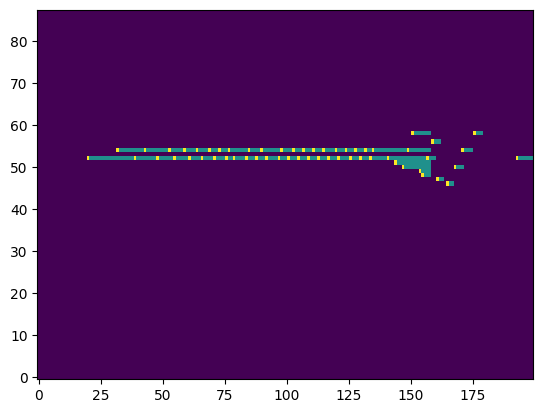

In [61]:
from math import ceil
import torch
# convert MIDI Notes to piano roll
# piano roll: [88 (entire pitch), T (time frame)]
sr = 16000
fft_size = 1024
hop_size = 512

hop_second = 0.032 # 512 / 16000
# duration = info['duration']

duration = max([note['offset'] for note in entire_notes[-10:]])
total_num_frame = ceil(duration / hop_second)

piano_roll = torch.zeros(88, total_num_frame, dtype=torch.int8)
onset_roll = torch.zeros(88, total_num_frame, dtype=torch.int8)

for note in entire_notes:
  pitch = note['note'] - 21 # lowest MIDI pitch of piano: 21
  onset_frame = int(note['onset'] // hop_second)
  offset_frame = int(note['offset'] // hop_second) + 1
  piano_roll[pitch, onset_frame:offset_frame] = 1
  onset_roll[pitch, onset_frame] = 1

piano_roll += onset_roll
import matplotlib.pyplot as plt

plt.imshow(piano_roll[:, :200], aspect='auto', origin='lower', interpolation='none')

In [60]:
total_num_frame, onset_frame, offset_frame

(10961, 10938, 10961)

## 2. Model

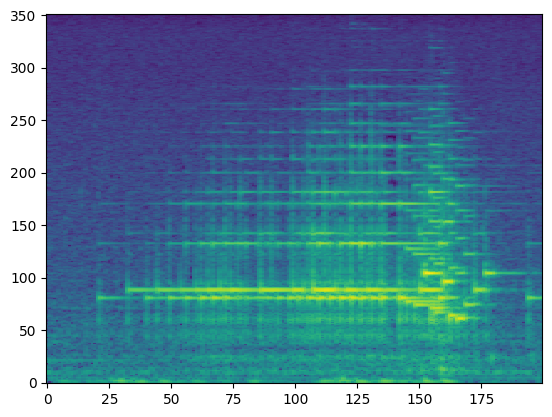

In [17]:
import torch.nn as nn

class SpecConverter(nn.Module):
  def __init__(self):
    super().__init__()
    self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=352) # 352 = 88 * 4
    self.db = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db(self.mel(x)) / 80

converter = SpecConverter()
spec = converter(y)[0]




In [44]:
spec.shape, piano_roll.shape, piano_roll.dtype

(torch.Size([352, 10993]), torch.Size([88, 10940]), torch.int8)

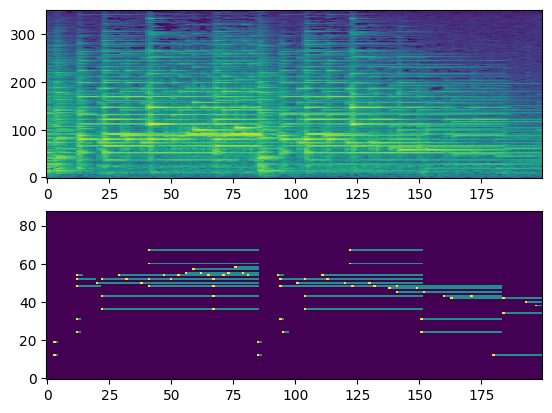

In [40]:
idx1 = 8000
idx2 = idx1+200

plt.subplot(2,1,1)
plt.imshow(spec[:, idx1:idx2], aspect='auto', origin='lower', interpolation='none')
plt.subplot(2,1,2)
plt.imshow(piano_roll[:, idx1:idx2], aspect='auto', origin='lower', interpolation='none')

In [76]:
import random
from tqdm.auto import tqdm

class Dataset:
  def __init__(self, data_dir, max_data=200):
    self.dir = Path(data_dir)
    json_path = self.dir / 'data.json'
    with open(json_path, 'r') as f:
      self.meta = json.load(f)
    self.meta = self.meta[:max_data]
    self.pedal_threshold = 64
    self.sr = 16000
    self.fft_size = 2048
    self.hop_size = 512

    self.hop_second = self.hop_size / self.sr
    self.slice_frame = int(15 / self.hop_second)
    self.piano_rolls = self.process_entire_midi()
    self.audios = self.load_entire_audio()


  def __len__(self):
    return len(meta)

  def __getitem__(self, idx):
    roll = self.piano_rolls[idx]
    audio = self.audios[idx]

    slice_start = random.randint(0, roll.shape[1] - self.slice_frame)
    slice_start_sec = slice_start * self.hop_second
    roll = roll[:, slice_start:slice_start+self.slice_frame]
    audio = audio[:, int(slice_start_sec*sr):int((slice_start_sec+15)*sr)]

    return audio, roll

  def load_entire_audio(self):
    audios = []
    for info in tqdm(self.meta):
      audio_fn = (self.dir / info['audio_filename']).with_suffix('.flac')
      y, sr = torchaudio.load(audio_fn)
      audios.append(y)
    return audios

  def process_entire_midi(self):
    entire_rolls = []
    for info in tqdm(self.meta):
      midi_fn = info['midi_filename']
      midi_fn = self.dir / midi_fn
      piano_roll = self.pre_process_midi(midi_fn)
      entire_rolls.append(piano_roll)
    return entire_rolls

  def pre_process_midi(self, midi_fn):
    midi_obj = MidiFile(midi_fn)
    parsed_notes = self.parse_midi_notes(midi_obj)
    piano_roll, onset_roll = self.make_piano_roll(parsed_notes)
    return piano_roll

  def make_piano_roll(self, entire_notes:dict):
    # duration = info['duration']
    duration = max([note['offset'] for note in entire_notes[-10:]])
    total_num_frame = ceil(duration / self.hop_second)

    piano_roll = torch.zeros(88, total_num_frame, dtype=torch.int8)
    onset_roll = torch.zeros(88, total_num_frame, dtype=torch.int8)

    for note in entire_notes:
      pitch = note['note'] - 21 # lowest MIDI pitch of piano: 21
      onset_frame = int(note['onset'] // self.hop_second)
      offset_frame = int(note['offset'] // self.hop_second) + 1
      piano_roll[pitch, onset_frame:offset_frame] = 1
      onset_roll[pitch, onset_frame] = 1
    return piano_roll, onset_roll

  def parse_midi_notes(self, midi_obj):
    pedal_treshold = self.pedal_threshold
    cur_time = 0
    entire_notes = []
    temp_notes = []
    cur_pedal = 0
    pedal_notes = []

    for message in midi_obj.merged_track:
      cur_time += message.time / 768
      if message.type == 'note_on':
        if message.velocity > 0: # note onset
          new_note = {'note': message.note, 'velocity': message.velocity, 'onset': cur_time}
          temp_notes.append(new_note)
        else: # note offset
          delete_ids = []
          for i, tmp_nt in enumerate(temp_notes):
            if message.note == tmp_nt['note']:
              if cur_pedal < pedal_threshold: # pedal is off
                tmp_nt['offset'] = cur_time
                entire_notes.append(tmp_nt)
              else:
                pedal_notes.append(tmp_nt)
              delete_ids.append(i)
          for idx in reversed(delete_ids):
            temp_notes.pop(idx)
      elif message.type == 'control_change' and message.control == 64:
        cur_pedal = message.value
        if cur_pedal < pedal_threshold:
          for tmp_nt in pedal_notes:
            tmp_nt['offset'] = cur_time
            entire_notes.append(tmp_nt)
          pedal_notes = []
      else:
        continue
    return entire_notes

dataset = Dataset('data/', max_data=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

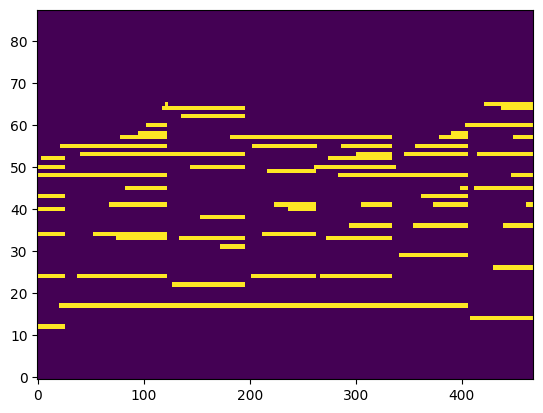

In [89]:
audio, roll = dataset[8]
audio.shape, roll.shape
ipd.display(ipd.Audio(audio, rate=16000))
plt.imshow(roll, aspect='auto', origin='lower', interpolation='none')

In [93]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4)
batch = next(iter(train_loader))
audios, rolls = batch

In [104]:
import torch.nn as nn

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.spec_converter = SpecConverter()
    self.layers = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,1)),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,1)),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
    )
    self.proj = nn.Linear(32 * 88, 88)

  def forward(self, audio):
    spec = self.spec_converter(audio)
    print(spec.shape)
    out = self.layers(spec)
    out = out.flatten(1,2) # N x (C x 88) x T
    out = out.permute(0, 2, 1) # N x T x (C x 88)
    out = self.proj(out) # N x T x 88
    return out.sigmoid()

model = Model()
out = model(audios)

torch.Size([4, 1, 352, 469])


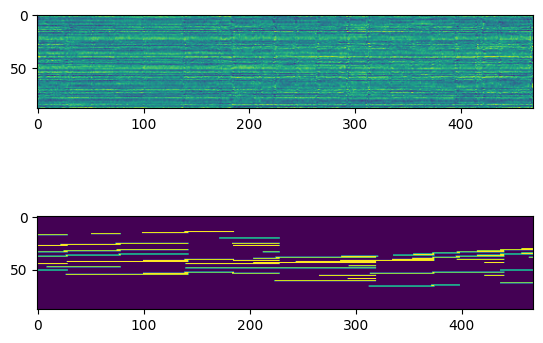

In [106]:
plt.subplot(2,1,1)
plt.imshow(out.detach()[0].T)
plt.subplot(2,1,2)
plt.imshow(rolls[0])

## 3. Training